In [1]:
import pandas as pd 
import pandasql as ps
import os
import datetime
import warnings
from IPython.display import Image
from IPython.display import display, HTML
warnings.filterwarnings('ignore')
display(HTML("<style>:root { --jp-notebook-max-width: 90% !important; }</style>"))

# 1. SQL Query – Cohort Analysis & Retention Trends

**Task:**

- Write an SQL query to conduct a **Cohort Analysis** that tracks user retention **for 7 days, segmented by Acquisition Date**.
- Extend beyond simple retention rates to **identify retention patterns by available dimensions**

**Expected Output:**

- a) SQL query
- b) A table summarizing **Day 1-7 retention trends** per cohort.
- c) Additional insights into retention patterns

<aside>
📌 **Evaluation Focus:** SQL efficiency, correctness, cohort-based approach.

</aside>

# Load Data

In [2]:
## Load dataset (Specify file name)
target_dir = 'data'
target_file = 'frvr-businesscase-dataset-3-.csv'
target_file_path = os.path.join(target_dir, target_file)

## Load dataset
frvr_user_events_raw = pd.read_csv(target_file_path, delimiter = ',')

## Drop duplicates
frvr_user_events_raw = frvr_user_events_raw.drop_duplicates()


## Read first 3 rows
#frvr_user_events_raw.head(3)

# Add useful new columns
frvr_user_events_raw['acquisition_date'] = pd.to_datetime(frvr_user_events_raw['acquisition_date'])
frvr_user_events_raw['date'] = pd.to_datetime(frvr_user_events_raw['date'])
frvr_user_events_raw['days_since_acquisition'] = (frvr_user_events_raw['date'] - frvr_user_events_raw['acquisition_date']).dt.days

#### a) SQL Query

In [3]:
query = """
with frvr_users_retained_raw as (
    select 
          acquisition_date
        , date as event_date
        , julianday(date) - julianday(acquisition_date) as days_since_acquisition
        , count(distinct user_id) as users
    from frvr_user_events_raw
    group by 1,2,3 order by 1 asc
),
frvr_users_retained_formatted as (
    select 
          acquisition_date
        , cast(sum(case when days_since_acquisition = 0 then users end) as real) as users_acquired
        , sum(case when days_since_acquisition = 1 then users end) as users_retained_d1
        , sum(case when days_since_acquisition = 2 then users end) as users_retained_d2
        , sum(case when days_since_acquisition = 3 then users end) as users_retained_d3
        , sum(case when days_since_acquisition = 4 then users end) as users_retained_d4
        , sum(case when days_since_acquisition = 5 then users end) as users_retained_d5
        , sum(case when days_since_acquisition = 6 then users end) as users_retained_d6
        , sum(case when days_since_acquisition = 7 then users end) as users_retained_d7
    from frvr_users_retained_raw
    group by 1 
    order by 1 asc
),
frvr_users_retained_final as (
    select
          acquisition_date as "Acquisition Date"
        , users_acquired as "Users Acquired"
        , round(users_retained_d1 / users_acquired,3) as 'D1'
        , round(users_retained_d2 / users_acquired,3) as 'D2'
        , round(users_retained_d3 / users_acquired,3) as 'D3'
        , round(users_retained_d4 / users_acquired,3) as 'D4'
        , round(users_retained_d5 / users_acquired,3) as 'D5'
        , round(users_retained_d6 / users_acquired,3) as 'D6'
        , round(users_retained_d7 / users_acquired,3) as 'D7'
    from frvr_users_retained_formatted
    group by 1
    order by 1 asc
)
select * from frvr_users_retained_final
    """

## Load data
result = ps.sqldf(query, locals())

# Show first 5 rows
result.head(5)

,Acquisition Date,Users Acquired,D1,D2,D3,D4,D5,D6,D7
0,2022-10-07 00:00:00.000000,6160.0,0.149,0.112,0.091,0.074,0.068,0.057,0.054
1,2022-10-08 00:00:00.000000,5788.0,0.161,0.109,0.084,0.071,0.065,0.064,0.055
2,2022-10-09 00:00:00.000000,6158.0,0.151,0.093,0.086,0.068,0.065,0.053,0.058
3,2022-10-10 00:00:00.000000,6560.0,0.151,0.103,0.098,0.073,0.062,0.061,0.055
4,2022-10-11 00:00:00.000000,4872.0,0.154,0.101,0.083,0.064,0.063,0.053,0.038


#### b) Summary Table: Day 1-7 retention trends per cohort

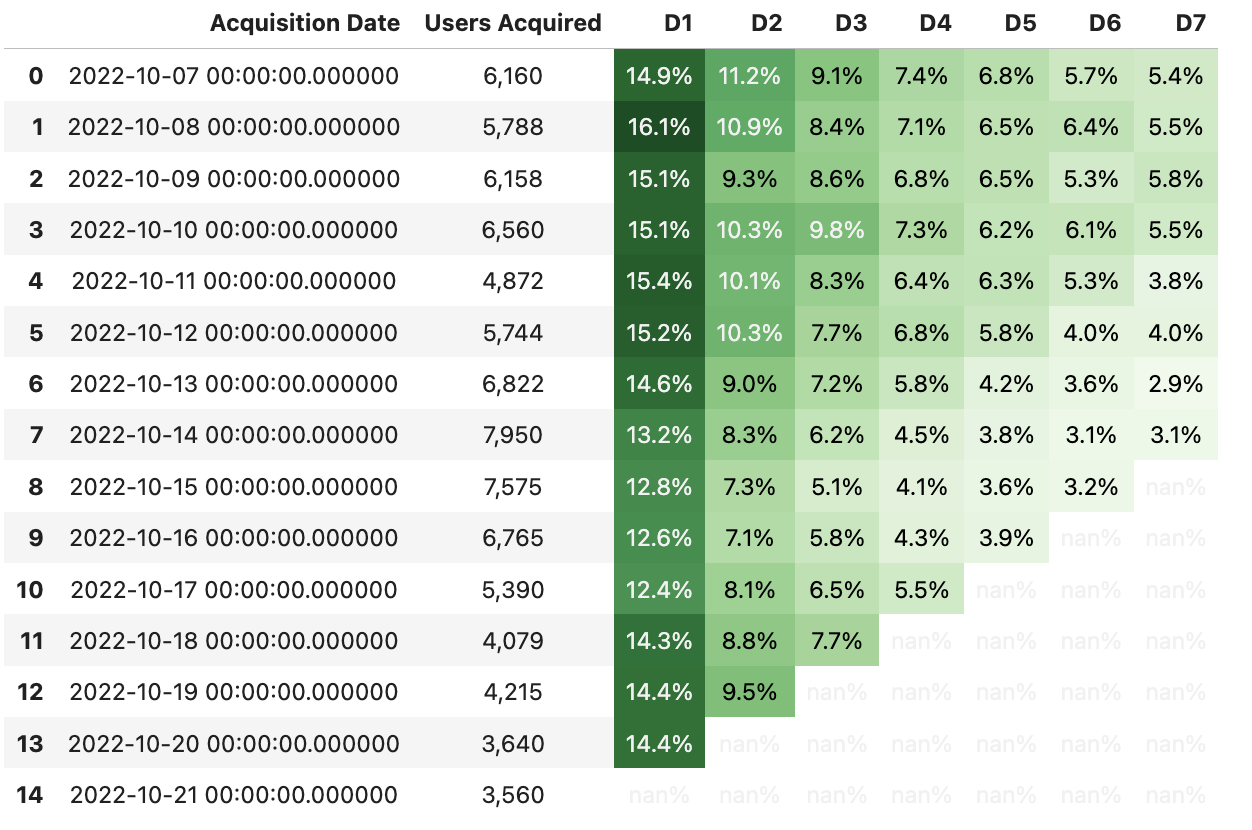

In [4]:
# Target columns for pct formatting
day_cols = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7']


# Format result (Number formatting, conditional formatting & Centering data)
styled_result = result.style \
        .format({
        **{col: "{:.1%}" for col in day_cols},           # Format D1–D7 as percentages
        'Users Acquired': "{:,.0f}"                      # Format with commas, no decimals
    }) \
    .background_gradient(subset=day_cols, cmap='Greens', vmin=0.02, vmax=0.165) \
    .highlight_null(color='white') \
    .set_properties(**{'text-align': 'center'})

## Display Styled Result (Conditional formatting of chart doesn't work in GitHub. Hiding result and importing as a PNG image below)
#styled_result
Image(filename='images/task_1a_styled_result_image.png', width=800) 

#### c) Additional Insights

- We see a noticeable decrease in D1 Retention for users acquired between October 14th and October 17th

  
- Below we calculate the average retention rate curves between 'control_group' and 'test_group' of the experiment
- Although the method is imperfect (it's not a weighted based on the size of the cohort (users)) it is useful for quick observations.
- Generally the retetention curves behave identical, with one exception:
- There is an increase in retention for the test_group between day 8 - 12. This is surprising and should be investigated further!

  

##### % Avg. Retention Rate: Control vs Test Group

<Axes: xlabel='days_since_acquisition'>

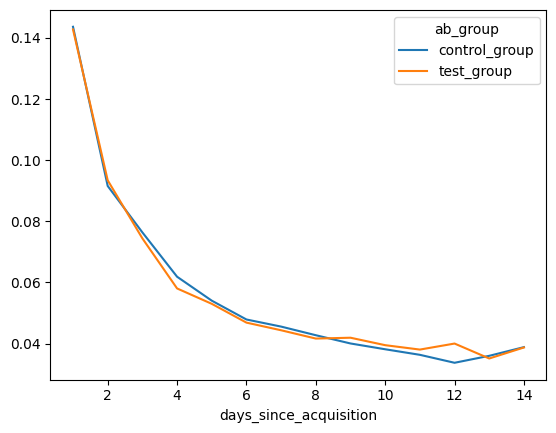

In [5]:
retention_rate = frvr_user_events_raw.groupby(['acquisition_date','days_since_acquisition','ab_group'])['user_id'].nunique().reset_index()

#Rename column (user_id to users)
retention_rate = retention_rate.rename(columns={'user_id':'users'}) 

# Create new column which corresponds to initial users within each cohort (users at day 0)
retention_rate['users_acquired'] =  retention_rate.sort_values(['acquisition_date', 'days_since_acquisition']).groupby(['acquisition_date','ab_group'])['users'].transform('first')

# Create new column (users_retained)
retention_rate['users_retained'] =  retention_rate['users'] / retention_rate['users_acquired']

# Exclude D0
retention_rate = retention_rate[retention_rate['days_since_acquisition'] >= 1]  

# Get average retention_rate across all acquisition_date cohorts
retention_rate = retention_rate.groupby(['days_since_acquisition','ab_group'])['users_retained'].mean().reset_index()

# Pivot data to prepare for visualisation
retention_rate = retention_rate.pivot(index='days_since_acquisition', columns = 'ab_group', values = 'users_retained')


#sns.lineplot(retention_rate)
retention_rate.plot()